<a href="https://colab.research.google.com/github/aminekhasteh/DeepLearningFinalReport2020/blob/master/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
main_dir = '/content/drive/My Drive/Colab Notebooks/Breast Cancer'

In [ ]:
csv_stage = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Breast Cancer/brca-clinicalforwiki_TCIA.xlsx')

In [ ]:
# Converting the training data into tensor
training_names = os.listdir(main_dir + '/' + 'Training')
names=training_names[0]
miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
miz = miz.convert("L")
new = np.asarray(miz)
new_normalised = new/(new.max())
training_tensor = np.expand_dims(new_normalised, axis=0)
Y = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
j=1
for names in training_names[1:]:
    Y.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[j][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    j=j+1
    miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = (new-new.mean())/new.std()
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    training_tensor = np.concatenate((training_tensor, new_tensor), axis=0)

In [ ]:
training_tensor.shape

(594, 256, 256)

In [ ]:
# Converting the testing data into tensor
testing_names = os.listdir(main_dir + '/' + 'Testing')
names=testing_names[0]
miz1 = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
miz1 = miz.convert("L")
new1 = np.asarray(miz1)
new_normalised1 = new/(new1.max())
testing_tensor = np.expand_dims(new_normalised1, axis=0)
Y_test = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
k = 1
for names in testing_names[1:]:
    Y_test.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[k][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    k=k+1
    miz = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = (new-new.mean())/new.std()
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    testing_tensor = np.concatenate((testing_tensor, new_tensor), axis=0)

In [ ]:
testing_tensor.shape

(152, 256, 256)

In [ ]:
# Expanding the dataset one more time
training_tensor = np.expand_dims(training_tensor, axis=3)
testing_tensor = np.expand_dims(testing_tensor, axis=3)

In [ ]:
# About Dataset:
print('Training shape:', training_tensor.shape)
print(training_tensor.shape[0], 'sample,',training_tensor.shape[1] ,'x',training_tensor.shape[2] ,'size grayscale image.\n')
print('Test shape:', testing_tensor.shape)
print(testing_tensor.shape[0], 'sample,',testing_tensor.shape[1] ,'x',testing_tensor.shape[2] ,'size grayscale image.\n')

Training shape: (594, 256, 256, 1)
594 sample, 256 x 256 size grayscale image.

Test shape: (152, 256, 256, 1)
152 sample, 256 x 256 size grayscale image.



Examples:


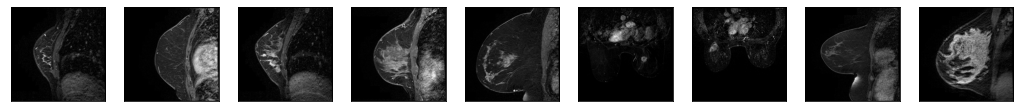

In [ ]:
print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(training_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# Describe the number of classes:
num_class = 7

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dense, Activation, Lambda, Reshape, Flatten
from keras.models import Model
from keras import backend as K

# Custom classifier function:
def classifier_func(x):
    return x+x*K.one_hot(K.argmax(x, axis=1), num_classes=num_class)

In [ ]:
# Deep Learning Model:

inputs = Input(shape=(256, 256, 1))
#Encoder:
conv_1 = Conv2D(32, (3,3), strides=(1,1))(inputs)
act_1 = Activation('relu')(conv_1)
maxpool_1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(act_1)

conv_2 = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(maxpool_1)
act_2 = Activation('relu')(conv_2)
maxpool_2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(act_2)
# Output Shape: 6x6x64
    
flat_1 = Flatten()(maxpool_2)

fc_1 = Dense(256)(flat_1)
act_3 = Activation('relu')(fc_1)

fc_2 = Dense(128)(act_3)
act_4 = Activation('relu')(fc_2)

fc_3 = Dense(num_class)(act_4)

act_class = Lambda(classifier_func, output_shape=(num_class,))(fc_3)
# Output Shape: 7

#Decoder:
fc_4 = Dense(256)(act_class)
act_5 = Activation('relu')(fc_4)

fc_5 = Dense(254016)(act_5)
act_6 = Activation('relu')(fc_5)
reshape_1 = Reshape((63,63,64))(act_6)

upsample_1 = UpSampling2D((2, 2))(reshape_1)
deconv_1 = Conv2DTranspose(64, (3, 3), strides=(1, 1))(upsample_1)
act_7 = Activation('relu')(deconv_1)

upsample_2 = UpSampling2D((2, 2))(act_7)
deconv_2 = Conv2DTranspose(32, (3, 3), strides=(1, 1))(upsample_2)
act_8 = Activation('relu')(deconv_2)

conv_3 = Conv2D(1, (3, 3), strides=(1, 1))(act_8)
act_9 = Activation('sigmoid')(conv_3)
# Output Shape: 28x28x1

autoencoder = Model(inputs, act_9)
opt = keras.optimizers.Adadelta(learning_rate=0.007,rho=0.999)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 127, 127, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)       

In [ ]:
epochs = 250
batch_size = 128
checkpoints = []

In [ ]:
%reload_ext tensorboard

In [ ]:
! mkdir /tmp/autoencoder


In [ ]:
# Training Model:
from keras.callbacks import TensorBoard
! rm -r /tmp/autoencoder
autoencoder.fit(training_tensor, training_tensor, batch_size=batch_size, 
                epochs=epochs, validation_data=(testing_tensor, testing_tensor), 
                shuffle=True,
                callbacks=checkpoints)

Epoch 1/250
5/5 [==============================] - 7s 1s/step - loss: 0.6924 - val_loss: 0.6909
Epoch 2/250
5/5 [==============================] - 4s 861ms/step - loss: 0.6900 - val_loss: 0.6883
Epoch 3/250
5/5 [==============================] - 4s 869ms/step - loss: 0.6873 - val_loss: 0.6855
Epoch 4/250
5/5 [==============================] - 4s 876ms/step - loss: 0.6844 - val_loss: 0.6826
Epoch 5/250
5/5 [==============================] - 4s 884ms/step - loss: 0.6815 - val_loss: 0.6797
Epoch 6/250
5/5 [==============================] - 4s 897ms/step - loss: 0.6785 - val_loss: 0.6767
Epoch 7/250
5/5 [==============================] - 5s 906ms/step - loss: 0.6755 - val_loss: 0.6735
Epoch 8/250
5/5 [==============================] - 5s 921ms/step - loss: 0.6723 - val_loss: 0.6703
Epoch 9/250
5/5 [==============================] - 5s 930ms/step - loss: 0.6691 - val_loss: 0.6670
Epoch 10/250
5/5 [==============================] - 5s 933ms/step - loss: 0.6656 - val_loss: 0.6634
Epoch 11/250

In [ ]:
# tensorboard --logdir=/tmp/autoencoder

In [ ]:
decoded_imgs = autoencoder.predict(testing_tensor)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(testing_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# Split autoencoder:
encoder = Model(inputs, act_class)
encoder.summary()

In [ ]:
# Results on training

encode = encoder.predict(training_tensor)

class_dict = np.zeros((num_class, num_class))
for i, sample in enumerate(Y):
    if sample=='Stage I':
        class_dict[np.argmax(encode[i], axis=0)][1] += 1
    if sample=='Stage IA':
        class_dict[np.argmax(encode[i], axis=0)][2] += 1
    if sample=='Stage II':
        class_dict[np.argmax(encode[i], axis=0)][3] += 1
    if sample=='Stage IIA':
        class_dict[np.argmax(encode[i], axis=0)][4] += 1
    if sample=='Stage IIB':
        class_dict[np.argmax(encode[i], axis=0)][5] += 1
    if sample=='Stage IIIA':
        class_dict[np.argmax(encode[i], axis=0)][6] += 1
    if sample=='Stage IIIB':
        class_dict[np.argmax(encode[i], axis=0)][7] += 1

print(class_dict)
    
neuron_class = np.zeros((num_class))
for i in range(num_class):
    neuron_class[i] = np.argmax(class_dict[i], axis=0)

print(neuron_class)

In [ ]:
# Results on testing

encode = encoder.predict(testing_tensor)

predicted = np.argmax(encode, axis=1)
for i, sample in enumerate(predicted):
    predicted[i] = neuron_class[predicted[i]]

comparison = []
for i in range(len(Y_test)):
    if predicted[i]==1:
        pred = 'Stage I'
    if predicted[i]==2:
        pred = 'Stage IA'
    if predicted[i]==3:
        pred = 'Stage II'
    if predicted[i]==4:
        pred = 'Stage IIA'
    if predicted[i]==5:
        pred = 'Stage IIB'
    if predicted[i]==6:
        pred = 'Stage IIIA'
    if predicted[i]==7:
        pred = 'Stage IIIB'
        
    if Y_test[i]==pred:
        comparison.append(1)
    else:
        comparison.append(0)

loss = 1 - np.sum(comparison)/len(Y_test)

print('Loss:', loss)
print('Examples:')
for i in range(10):
    plt.imshow(testing_tensor[i].reshape(256,256), cmap='gray')
    plt.axis('off')
    plt.show()
    neuron = np.argmax(encode[i], axis=0)
    print('Class:', Y_test[i], '- Model\'s Output Class:', neuron_class[neuron])